# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [6]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=250  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=512, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=64, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=64, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [7]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=True)
        
        #------------------------ 另一半 ----------------------------
        self.scaleLayer= nn.Conv1d(1, 1, 1, stride=1,padding=0,groups=1,dilation=1,bias=True)
        
        one_conv_kernel_size = 9 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=4,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        #w=w[0]-torch.mean(w[0])
    
        a=torch.randn(1).cuda()*0.1
        b=int(a*10)
        if b>0:
            w=w[b]
        else:
            w=w[0]
        #w=torch.randn(w[0].shape).cuda()*1
        
        
        if a>0.38:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        
        w=self.scaleLayer(w)  #自动缩放层
        
        if a>0.38:
            print(self.scaleLayer.weight)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        
        #-------------------------------------
        w = 0.1*F.tanh(w) # [-0.5,+0.5]
        #w=F.softmax(w,dim=2)
        
        if a>0.38:
            print(self.conv1D.weight.shape)
            print(self.conv1D.weight)
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [8]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150,200,230,250], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [9]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [10]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [11]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [12]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [13]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.312374, Accuracy: 8.40
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.287128, Accuracy: 12.11
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.409006, Accuracy: 9.96
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.291906, Accuracy: 15.82
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.118192, Accuracy: 16.41
Train Epoch: 0 [12800/50000 (28%)]	Loss: 2.143291, Accuracy: 18.75
Train Epoch: 0 [15360/50000 (34%)]	Loss: 2.080678, Accuracy: 16.60
Train Epoch: 0 [17920/50000 (40%)]	Loss: 2.066051, Accuracy: 17.77
Train Epoch: 0 [20480/50000 (45%)]	Loss: 2.041112, Accuracy: 19.14
Train Epoch: 0 [23040/50000 (51%)]	Loss: 2.098235, Accuracy: 16.21
Train Epoch: 0 [25600/50000 (57%)]	Loss: 2.010013, Accuracy: 20.31
Train Epoch: 0 [28160/50000 (62%)]	Loss: 2.002409, Accuracy: 18.36
Train Epoch: 0 [30720/50000 (68%)]	Loss: 1.953667, Accuracy: 22.66
Train Epoch: 0 [33280/50000 (74%)]	Loss: 1.892114, Accuracy: 23.83
Train Epoch: 0 [35840/50000 (80%)]	Loss: 1.915963, Accuracy: 21.88
Train 

Train Epoch: 6 [15360/50000 (34%)]	Loss: 0.835050, Accuracy: 70.90
Train Epoch: 6 [17920/50000 (40%)]	Loss: 0.962406, Accuracy: 65.23
Train Epoch: 6 [20480/50000 (45%)]	Loss: 0.947665, Accuracy: 66.02
Train Epoch: 6 [23040/50000 (51%)]	Loss: 0.856692, Accuracy: 70.12
Train Epoch: 6 [25600/50000 (57%)]	Loss: 0.924749, Accuracy: 67.97
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.876170, Accuracy: 70.31
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.901693, Accuracy: 67.38
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.921376, Accuracy: 68.95
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.903185, Accuracy: 68.55
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.893723, Accuracy: 67.58
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.847425, Accuracy: 68.75
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.764510, Accuracy: 73.83

Validation set: Average loss: 1.5305, Accuracy: 2640/5000 (52.00%)

the time of this epoch:[36.14425015449524 s]
Train Epoch: 7 [0/50000 (0%)]	Loss: 0.824841, Accuracy: 70.90
Train Epoch: 7 [2560

Train Epoch: 12 [25600/50000 (57%)]	Loss: 0.603176, Accuracy: 80.27
Train Epoch: 12 [28160/50000 (62%)]	Loss: 0.504126, Accuracy: 83.40
Train Epoch: 12 [30720/50000 (68%)]	Loss: 0.528756, Accuracy: 83.79
Train Epoch: 12 [33280/50000 (74%)]	Loss: 0.528735, Accuracy: 81.05
Train Epoch: 12 [35840/50000 (80%)]	Loss: 0.501542, Accuracy: 82.23
Train Epoch: 12 [38400/50000 (85%)]	Loss: 0.572487, Accuracy: 78.71
Train Epoch: 12 [40960/50000 (91%)]	Loss: 0.521336, Accuracy: 82.81
Train Epoch: 12 [43520/50000 (97%)]	Loss: 0.554190, Accuracy: 80.66

Validation set: Average loss: 0.7190, Accuracy: 3812/5000 (76.00%)

the time of this epoch:[36.19081139564514 s]

Test set: Average loss: 0.7391, Accuracy: 7544/10000 (75.44%)

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.471201, Accuracy: 83.98
Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.470191, Accuracy: 83.01
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.472583, Accuracy: 85.35
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.454925, Accuracy: 85.16
Train Epoch: 13

Train Epoch: 18 [28160/50000 (62%)]	Loss: 0.391437, Accuracy: 86.72
Train Epoch: 18 [30720/50000 (68%)]	Loss: 0.403349, Accuracy: 85.94
Train Epoch: 18 [33280/50000 (74%)]	Loss: 0.464354, Accuracy: 84.38
Train Epoch: 18 [35840/50000 (80%)]	Loss: 0.467567, Accuracy: 83.59
Train Epoch: 18 [38400/50000 (85%)]	Loss: 0.530099, Accuracy: 82.23
Train Epoch: 18 [40960/50000 (91%)]	Loss: 0.498620, Accuracy: 83.79
Train Epoch: 18 [43520/50000 (97%)]	Loss: 0.391063, Accuracy: 86.91

Validation set: Average loss: 0.5294, Accuracy: 4091/5000 (81.00%)

the time of this epoch:[36.23074126243591 s]

Test set: Average loss: 0.5576, Accuracy: 8221/10000 (82.21%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.351189, Accuracy: 87.11
Train Epoch: 19 [2560/50000 (6%)]	Loss: 0.366572, Accuracy: 89.45
Train Epoch: 19 [5120/50000 (11%)]	Loss: 0.378493, Accuracy: 86.72
Train Epoch: 19 [7680/50000 (17%)]	Loss: 0.371992, Accuracy: 88.09
Train Epoch: 19 [10240/50000 (23%)]	Loss: 0.362681, Accuracy: 87.30
Train Epoch: 19


Test set: Average loss: 0.6116, Accuracy: 8005/10000 (80.05%)

Train Epoch: 21 [0/50000 (0%)]	Loss: 0.447247, Accuracy: 86.33
Train Epoch: 21 [2560/50000 (6%)]	Loss: 0.374333, Accuracy: 87.11
Train Epoch: 21 [5120/50000 (11%)]	Loss: 0.342422, Accuracy: 89.26
Train Epoch: 21 [7680/50000 (17%)]	Loss: 0.349634, Accuracy: 87.30
Train Epoch: 21 [10240/50000 (23%)]	Loss: 0.436441, Accuracy: 84.96
Train Epoch: 21 [12800/50000 (28%)]	Loss: 0.376149, Accuracy: 88.28
Train Epoch: 21 [15360/50000 (34%)]	Loss: 0.331631, Accuracy: 88.87
Train Epoch: 21 [17920/50000 (40%)]	Loss: 0.356735, Accuracy: 88.67
Train Epoch: 21 [20480/50000 (45%)]	Loss: 0.424915, Accuracy: 85.94
Train Epoch: 21 [23040/50000 (51%)]	Loss: 0.386840, Accuracy: 86.13
Train Epoch: 21 [25600/50000 (57%)]	Loss: 0.366143, Accuracy: 87.70
Train Epoch: 21 [28160/50000 (62%)]	Loss: 0.410418, Accuracy: 85.55
Train Epoch: 21 [30720/50000 (68%)]	Loss: 0.361606, Accuracy: 86.33
Train Epoch: 21 [33280/50000 (74%)]	Loss: 0.412877, Accuracy:

Train Epoch: 27 [0/50000 (0%)]	Loss: 0.311658, Accuracy: 89.45
Train Epoch: 27 [2560/50000 (6%)]	Loss: 0.264938, Accuracy: 90.23
Train Epoch: 27 [5120/50000 (11%)]	Loss: 0.270589, Accuracy: 91.60
Train Epoch: 27 [7680/50000 (17%)]	Loss: 0.313695, Accuracy: 90.23
Train Epoch: 27 [10240/50000 (23%)]	Loss: 0.325111, Accuracy: 87.70
Train Epoch: 27 [12800/50000 (28%)]	Loss: 0.321595, Accuracy: 89.26
Train Epoch: 27 [15360/50000 (34%)]	Loss: 0.278813, Accuracy: 91.80
Train Epoch: 27 [17920/50000 (40%)]	Loss: 0.315434, Accuracy: 89.65
Train Epoch: 27 [20480/50000 (45%)]	Loss: 0.356437, Accuracy: 88.09
Train Epoch: 27 [23040/50000 (51%)]	Loss: 0.331934, Accuracy: 89.84
Train Epoch: 27 [25600/50000 (57%)]	Loss: 0.261643, Accuracy: 90.43
Train Epoch: 27 [28160/50000 (62%)]	Loss: 0.438408, Accuracy: 84.57
Train Epoch: 27 [30720/50000 (68%)]	Loss: 0.291922, Accuracy: 90.62
Train Epoch: 27 [33280/50000 (74%)]	Loss: 0.311205, Accuracy: 89.45
Train Epoch: 27 [35840/50000 (80%)]	Loss: 0.361381, Accur

Train Epoch: 33 [2560/50000 (6%)]	Loss: 0.326753, Accuracy: 88.09
Train Epoch: 33 [5120/50000 (11%)]	Loss: 0.291088, Accuracy: 90.43
Train Epoch: 33 [7680/50000 (17%)]	Loss: 0.261651, Accuracy: 91.99
Train Epoch: 33 [10240/50000 (23%)]	Loss: 0.259240, Accuracy: 91.02
Train Epoch: 33 [12800/50000 (28%)]	Loss: 0.346639, Accuracy: 87.50
Train Epoch: 33 [15360/50000 (34%)]	Loss: 0.297376, Accuracy: 90.62
Train Epoch: 33 [17920/50000 (40%)]	Loss: 0.325862, Accuracy: 89.84
Train Epoch: 33 [20480/50000 (45%)]	Loss: 0.281651, Accuracy: 91.21
Train Epoch: 33 [23040/50000 (51%)]	Loss: 0.281637, Accuracy: 89.26
Train Epoch: 33 [25600/50000 (57%)]	Loss: 0.304104, Accuracy: 87.70
Train Epoch: 33 [28160/50000 (62%)]	Loss: 0.298592, Accuracy: 90.04
Train Epoch: 33 [30720/50000 (68%)]	Loss: 0.289707, Accuracy: 90.62
Train Epoch: 33 [33280/50000 (74%)]	Loss: 0.324707, Accuracy: 89.65
Train Epoch: 33 [35840/50000 (80%)]	Loss: 0.314459, Accuracy: 89.84
Train Epoch: 33 [38400/50000 (85%)]	Loss: 0.341872, 

Train Epoch: 39 [5120/50000 (11%)]	Loss: 0.307202, Accuracy: 88.87
Train Epoch: 39 [7680/50000 (17%)]	Loss: 0.297366, Accuracy: 90.04
Train Epoch: 39 [10240/50000 (23%)]	Loss: 0.285955, Accuracy: 89.26
Train Epoch: 39 [12800/50000 (28%)]	Loss: 0.259986, Accuracy: 90.62
Train Epoch: 39 [15360/50000 (34%)]	Loss: 0.311813, Accuracy: 90.04
Train Epoch: 39 [17920/50000 (40%)]	Loss: 0.310835, Accuracy: 90.04
Train Epoch: 39 [20480/50000 (45%)]	Loss: 0.325281, Accuracy: 89.06
Train Epoch: 39 [23040/50000 (51%)]	Loss: 0.277799, Accuracy: 91.41
Train Epoch: 39 [25600/50000 (57%)]	Loss: 0.281467, Accuracy: 89.45
Train Epoch: 39 [28160/50000 (62%)]	Loss: 0.258777, Accuracy: 90.62
Train Epoch: 39 [30720/50000 (68%)]	Loss: 0.301334, Accuracy: 89.65
Train Epoch: 39 [33280/50000 (74%)]	Loss: 0.306423, Accuracy: 91.21
Train Epoch: 39 [35840/50000 (80%)]	Loss: 0.390896, Accuracy: 85.74
Train Epoch: 39 [38400/50000 (85%)]	Loss: 0.298282, Accuracy: 89.84
Train Epoch: 39 [40960/50000 (91%)]	Loss: 0.325570

Train Epoch: 45 [7680/50000 (17%)]	Loss: 0.274513, Accuracy: 91.41
Train Epoch: 45 [10240/50000 (23%)]	Loss: 0.313814, Accuracy: 90.43
Train Epoch: 45 [12800/50000 (28%)]	Loss: 0.251389, Accuracy: 91.99
Train Epoch: 45 [15360/50000 (34%)]	Loss: 0.278732, Accuracy: 91.60
Train Epoch: 45 [17920/50000 (40%)]	Loss: 0.251907, Accuracy: 91.02
Train Epoch: 45 [20480/50000 (45%)]	Loss: 0.303156, Accuracy: 88.28
Train Epoch: 45 [23040/50000 (51%)]	Loss: 0.285710, Accuracy: 90.23
Train Epoch: 45 [25600/50000 (57%)]	Loss: 0.226236, Accuracy: 93.55
Train Epoch: 45 [28160/50000 (62%)]	Loss: 0.295111, Accuracy: 90.43
Train Epoch: 45 [30720/50000 (68%)]	Loss: 0.305507, Accuracy: 89.45
Train Epoch: 45 [33280/50000 (74%)]	Loss: 0.314644, Accuracy: 88.09
Train Epoch: 45 [35840/50000 (80%)]	Loss: 0.285060, Accuracy: 90.43
Train Epoch: 45 [38400/50000 (85%)]	Loss: 0.293140, Accuracy: 89.26
Train Epoch: 45 [40960/50000 (91%)]	Loss: 0.296282, Accuracy: 90.62
Train Epoch: 45 [43520/50000 (97%)]	Loss: 0.30675

Train Epoch: 51 [10240/50000 (23%)]	Loss: 0.230111, Accuracy: 91.80
Train Epoch: 51 [12800/50000 (28%)]	Loss: 0.253049, Accuracy: 91.80
Train Epoch: 51 [15360/50000 (34%)]	Loss: 0.207443, Accuracy: 92.19
Train Epoch: 51 [17920/50000 (40%)]	Loss: 0.242944, Accuracy: 91.80
Train Epoch: 51 [20480/50000 (45%)]	Loss: 0.244068, Accuracy: 92.58
Train Epoch: 51 [23040/50000 (51%)]	Loss: 0.329551, Accuracy: 88.67
Train Epoch: 51 [25600/50000 (57%)]	Loss: 0.306681, Accuracy: 90.43
Train Epoch: 51 [28160/50000 (62%)]	Loss: 0.256813, Accuracy: 91.21
Train Epoch: 51 [30720/50000 (68%)]	Loss: 0.310603, Accuracy: 88.28
Train Epoch: 51 [33280/50000 (74%)]	Loss: 0.275092, Accuracy: 91.80
Train Epoch: 51 [35840/50000 (80%)]	Loss: 0.333365, Accuracy: 89.26
Train Epoch: 51 [38400/50000 (85%)]	Loss: 0.207784, Accuracy: 93.55
Train Epoch: 51 [40960/50000 (91%)]	Loss: 0.322998, Accuracy: 88.67
Train Epoch: 51 [43520/50000 (97%)]	Loss: 0.243212, Accuracy: 90.23

Validation set: Average loss: 0.5530, Accuracy:


Test set: Average loss: 0.6192, Accuracy: 8031/10000 (80.31%)

Train Epoch: 53 [0/50000 (0%)]	Loss: 0.177981, Accuracy: 95.12
Train Epoch: 53 [2560/50000 (6%)]	Loss: 0.242297, Accuracy: 91.60
Train Epoch: 53 [5120/50000 (11%)]	Loss: 0.235703, Accuracy: 92.58
Train Epoch: 53 [7680/50000 (17%)]	Loss: 0.263265, Accuracy: 91.41
Train Epoch: 53 [10240/50000 (23%)]	Loss: 0.216199, Accuracy: 92.58
Train Epoch: 53 [12800/50000 (28%)]	Loss: 0.247149, Accuracy: 92.38
Train Epoch: 53 [15360/50000 (34%)]	Loss: 0.248757, Accuracy: 91.99
Train Epoch: 53 [17920/50000 (40%)]	Loss: 0.288978, Accuracy: 91.02
Train Epoch: 53 [20480/50000 (45%)]	Loss: 0.209892, Accuracy: 91.80
Train Epoch: 53 [23040/50000 (51%)]	Loss: 0.239415, Accuracy: 91.80
Train Epoch: 53 [25600/50000 (57%)]	Loss: 0.219059, Accuracy: 91.80
Train Epoch: 53 [28160/50000 (62%)]	Loss: 0.298933, Accuracy: 89.84
Train Epoch: 53 [30720/50000 (68%)]	Loss: 0.268749, Accuracy: 90.43
Train Epoch: 53 [33280/50000 (74%)]	Loss: 0.317753, Accuracy:


Validation set: Average loss: 0.4554, Accuracy: 4242/5000 (84.00%)

the time of this epoch:[39.80681252479553 s]
Train Epoch: 54 [0/50000 (0%)]	Loss: 0.289597, Accuracy: 90.43
Train Epoch: 54 [2560/50000 (6%)]	Loss: 0.267732, Accuracy: 90.62
Train Epoch: 54 [5120/50000 (11%)]	Loss: 0.221489, Accuracy: 92.77
Train Epoch: 54 [7680/50000 (17%)]	Loss: 0.266606, Accuracy: 89.84
Train Epoch: 54 [10240/50000 (23%)]	Loss: 0.192353, Accuracy: 93.75
Train Epoch: 54 [12800/50000 (28%)]	Loss: 0.248053, Accuracy: 91.02
Train Epoch: 54 [15360/50000 (34%)]	Loss: 0.258392, Accuracy: 89.84
Train Epoch: 54 [17920/50000 (40%)]	Loss: 0.235004, Accuracy: 92.97
Train Epoch: 54 [20480/50000 (45%)]	Loss: 0.167654, Accuracy: 94.14
Train Epoch: 54 [23040/50000 (51%)]	Loss: 0.245526, Accuracy: 91.80
Train Epoch: 54 [25600/50000 (57%)]	Loss: 0.237697, Accuracy: 92.97
Train Epoch: 54 [28160/50000 (62%)]	Loss: 0.278484, Accuracy: 91.02
Train Epoch: 54 [30720/50000 (68%)]	Loss: 0.283786, Accuracy: 90.43
Train Epoch

Train Epoch: 60 [0/50000 (0%)]	Loss: 0.257319, Accuracy: 91.21
Train Epoch: 60 [2560/50000 (6%)]	Loss: 0.243118, Accuracy: 90.62
Train Epoch: 60 [5120/50000 (11%)]	Loss: 0.185797, Accuracy: 94.14
Train Epoch: 60 [7680/50000 (17%)]	Loss: 0.224334, Accuracy: 93.16
Train Epoch: 60 [10240/50000 (23%)]	Loss: 0.183365, Accuracy: 92.97
Train Epoch: 60 [12800/50000 (28%)]	Loss: 0.146922, Accuracy: 95.12
Train Epoch: 60 [15360/50000 (34%)]	Loss: 0.258102, Accuracy: 92.77
Train Epoch: 60 [17920/50000 (40%)]	Loss: 0.213393, Accuracy: 92.19
Train Epoch: 60 [20480/50000 (45%)]	Loss: 0.221038, Accuracy: 92.38
Train Epoch: 60 [23040/50000 (51%)]	Loss: 0.250636, Accuracy: 91.80
Train Epoch: 60 [25600/50000 (57%)]	Loss: 0.237602, Accuracy: 91.60
Train Epoch: 60 [28160/50000 (62%)]	Loss: 0.289489, Accuracy: 90.82
Train Epoch: 60 [30720/50000 (68%)]	Loss: 0.339551, Accuracy: 88.67
Train Epoch: 60 [33280/50000 (74%)]	Loss: 0.290001, Accuracy: 90.04
Train Epoch: 60 [35840/50000 (80%)]	Loss: 0.199979, Accur

Train Epoch: 66 [2560/50000 (6%)]	Loss: 0.233889, Accuracy: 91.80
Train Epoch: 66 [5120/50000 (11%)]	Loss: 0.238596, Accuracy: 92.77
Train Epoch: 66 [7680/50000 (17%)]	Loss: 0.219845, Accuracy: 93.75
Train Epoch: 66 [10240/50000 (23%)]	Loss: 0.184713, Accuracy: 93.36
Train Epoch: 66 [12800/50000 (28%)]	Loss: 0.269745, Accuracy: 90.43
Train Epoch: 66 [15360/50000 (34%)]	Loss: 0.220212, Accuracy: 92.19
Train Epoch: 66 [17920/50000 (40%)]	Loss: 0.200274, Accuracy: 93.36
Train Epoch: 66 [20480/50000 (45%)]	Loss: 0.203591, Accuracy: 92.58
Train Epoch: 66 [23040/50000 (51%)]	Loss: 0.201809, Accuracy: 92.77
Train Epoch: 66 [25600/50000 (57%)]	Loss: 0.269401, Accuracy: 91.41
Train Epoch: 66 [28160/50000 (62%)]	Loss: 0.206134, Accuracy: 92.97
Train Epoch: 66 [30720/50000 (68%)]	Loss: 0.229479, Accuracy: 91.80
Train Epoch: 66 [33280/50000 (74%)]	Loss: 0.282040, Accuracy: 91.21
Train Epoch: 66 [35840/50000 (80%)]	Loss: 0.269288, Accuracy: 90.23
Train Epoch: 66 [38400/50000 (85%)]	Loss: 0.285442, 

Train Epoch: 70 [15360/50000 (34%)]	Loss: 0.186615, Accuracy: 94.73
Train Epoch: 70 [17920/50000 (40%)]	Loss: 0.261133, Accuracy: 91.02
Train Epoch: 70 [20480/50000 (45%)]	Loss: 0.250062, Accuracy: 90.62
Train Epoch: 70 [23040/50000 (51%)]	Loss: 0.248555, Accuracy: 90.82
Train Epoch: 70 [25600/50000 (57%)]	Loss: 0.291678, Accuracy: 89.26
Train Epoch: 70 [28160/50000 (62%)]	Loss: 0.245104, Accuracy: 91.80
Train Epoch: 70 [30720/50000 (68%)]	Loss: 0.274189, Accuracy: 89.26
Train Epoch: 70 [33280/50000 (74%)]	Loss: 0.283310, Accuracy: 90.43
Train Epoch: 70 [35840/50000 (80%)]	Loss: 0.192021, Accuracy: 93.55
Train Epoch: 70 [38400/50000 (85%)]	Loss: 0.184447, Accuracy: 94.14
Train Epoch: 70 [40960/50000 (91%)]	Loss: 0.269806, Accuracy: 89.84
Train Epoch: 70 [43520/50000 (97%)]	Loss: 0.298410, Accuracy: 89.65

Validation set: Average loss: 0.6182, Accuracy: 4076/5000 (81.00%)

the time of this epoch:[36.07134485244751 s]

Test set: Average loss: 0.6182, Accuracy: 8142/10000 (81.42%)

Train 

Train Epoch: 76 [17920/50000 (40%)]	Loss: 0.253794, Accuracy: 91.80
Train Epoch: 76 [20480/50000 (45%)]	Loss: 0.271001, Accuracy: 91.41
Train Epoch: 76 [23040/50000 (51%)]	Loss: 0.269532, Accuracy: 91.41
Train Epoch: 76 [25600/50000 (57%)]	Loss: 0.210465, Accuracy: 93.16
Train Epoch: 76 [28160/50000 (62%)]	Loss: 0.230038, Accuracy: 91.60
Train Epoch: 76 [30720/50000 (68%)]	Loss: 0.271103, Accuracy: 90.23
Train Epoch: 76 [33280/50000 (74%)]	Loss: 0.242343, Accuracy: 91.80
Train Epoch: 76 [35840/50000 (80%)]	Loss: 0.257316, Accuracy: 91.41
Train Epoch: 76 [38400/50000 (85%)]	Loss: 0.271870, Accuracy: 90.82
Train Epoch: 76 [40960/50000 (91%)]	Loss: 0.241794, Accuracy: 91.21
Train Epoch: 76 [43520/50000 (97%)]	Loss: 0.235096, Accuracy: 90.62

Validation set: Average loss: 0.4446, Accuracy: 4273/5000 (85.00%)

the time of this epoch:[36.24788451194763 s]

Test set: Average loss: 0.4789, Accuracy: 8465/10000 (84.65%)

Train Epoch: 77 [0/50000 (0%)]	Loss: 0.227032, Accuracy: 92.77
Train Epoch

Train Epoch: 81 [20480/50000 (45%)]	Loss: 0.215595, Accuracy: 92.19
Train Epoch: 81 [23040/50000 (51%)]	Loss: 0.244831, Accuracy: 91.60
Train Epoch: 81 [25600/50000 (57%)]	Loss: 0.269159, Accuracy: 91.41
Train Epoch: 81 [28160/50000 (62%)]	Loss: 0.178986, Accuracy: 94.34
Train Epoch: 81 [30720/50000 (68%)]	Loss: 0.220570, Accuracy: 92.19
Train Epoch: 81 [33280/50000 (74%)]	Loss: 0.254817, Accuracy: 91.21
Train Epoch: 81 [35840/50000 (80%)]	Loss: 0.243846, Accuracy: 91.99
Train Epoch: 81 [38400/50000 (85%)]	Loss: 0.314672, Accuracy: 90.62
Train Epoch: 81 [40960/50000 (91%)]	Loss: 0.272712, Accuracy: 92.19
Train Epoch: 81 [43520/50000 (97%)]	Loss: 0.276037, Accuracy: 90.23

Validation set: Average loss: 0.4456, Accuracy: 4274/5000 (85.00%)

the time of this epoch:[39.91375732421875 s]
Train Epoch: 82 [0/50000 (0%)]	Loss: 0.213650, Accuracy: 92.58
Train Epoch: 82 [2560/50000 (6%)]	Loss: 0.275235, Accuracy: 90.43
Train Epoch: 82 [5120/50000 (11%)]	Loss: 0.213399, Accuracy: 92.97
Train Epoc

Train Epoch: 87 [23040/50000 (51%)]	Loss: 0.275272, Accuracy: 90.62
Train Epoch: 87 [25600/50000 (57%)]	Loss: 0.205238, Accuracy: 92.77
Train Epoch: 87 [28160/50000 (62%)]	Loss: 0.226499, Accuracy: 91.80
Train Epoch: 87 [30720/50000 (68%)]	Loss: 0.216674, Accuracy: 91.80
Train Epoch: 87 [33280/50000 (74%)]	Loss: 0.216102, Accuracy: 92.77
Train Epoch: 87 [35840/50000 (80%)]	Loss: 0.304636, Accuracy: 88.28
Train Epoch: 87 [38400/50000 (85%)]	Loss: 0.197651, Accuracy: 93.55
Train Epoch: 87 [40960/50000 (91%)]	Loss: 0.260239, Accuracy: 90.04
Train Epoch: 87 [43520/50000 (97%)]	Loss: 0.247973, Accuracy: 92.38

Validation set: Average loss: 0.5963, Accuracy: 4116/5000 (82.00%)

the time of this epoch:[39.91755509376526 s]
Train Epoch: 88 [0/50000 (0%)]	Loss: 0.224538, Accuracy: 92.97
Train Epoch: 88 [2560/50000 (6%)]	Loss: 0.213102, Accuracy: 92.97
Train Epoch: 88 [5120/50000 (11%)]	Loss: 0.212543, Accuracy: 92.58
Train Epoch: 88 [7680/50000 (17%)]	Loss: 0.198278, Accuracy: 93.36
Train Epoch

Train Epoch: 93 [25600/50000 (57%)]	Loss: 0.231631, Accuracy: 92.19
Train Epoch: 93 [28160/50000 (62%)]	Loss: 0.265895, Accuracy: 90.82
Train Epoch: 93 [30720/50000 (68%)]	Loss: 0.293888, Accuracy: 90.23
Train Epoch: 93 [33280/50000 (74%)]	Loss: 0.189867, Accuracy: 94.34
Train Epoch: 93 [35840/50000 (80%)]	Loss: 0.248067, Accuracy: 91.99
Train Epoch: 93 [38400/50000 (85%)]	Loss: 0.226806, Accuracy: 92.58
Train Epoch: 93 [40960/50000 (91%)]	Loss: 0.181236, Accuracy: 93.16
Train Epoch: 93 [43520/50000 (97%)]	Loss: 0.167647, Accuracy: 94.34

Validation set: Average loss: 0.5109, Accuracy: 4201/5000 (84.00%)

the time of this epoch:[39.919368267059326 s]
Train Epoch: 94 [0/50000 (0%)]	Loss: 0.212782, Accuracy: 92.97
Train Epoch: 94 [2560/50000 (6%)]	Loss: 0.196883, Accuracy: 93.55
Train Epoch: 94 [5120/50000 (11%)]	Loss: 0.157008, Accuracy: 94.53
Train Epoch: 94 [7680/50000 (17%)]	Loss: 0.214446, Accuracy: 92.77
Train Epoch: 94 [10240/50000 (23%)]	Loss: 0.148572, Accuracy: 95.31
Train Epoc

Train Epoch: 99 [28160/50000 (62%)]	Loss: 0.256260, Accuracy: 91.02
Train Epoch: 99 [30720/50000 (68%)]	Loss: 0.261768, Accuracy: 91.21
Train Epoch: 99 [33280/50000 (74%)]	Loss: 0.268761, Accuracy: 93.16
Train Epoch: 99 [35840/50000 (80%)]	Loss: 0.230190, Accuracy: 91.60
Train Epoch: 99 [38400/50000 (85%)]	Loss: 0.200542, Accuracy: 92.38
Train Epoch: 99 [40960/50000 (91%)]	Loss: 0.250756, Accuracy: 91.80
Train Epoch: 99 [43520/50000 (97%)]	Loss: 0.230683, Accuracy: 92.77

Validation set: Average loss: 0.6551, Accuracy: 4087/5000 (81.00%)

the time of this epoch:[40.09692025184631 s]
Train Epoch: 100 [0/50000 (0%)]	Loss: 0.246901, Accuracy: 92.38
Train Epoch: 100 [2560/50000 (6%)]	Loss: 0.212532, Accuracy: 92.19
Train Epoch: 100 [5120/50000 (11%)]	Loss: 0.212281, Accuracy: 91.99
Train Epoch: 100 [7680/50000 (17%)]	Loss: 0.223848, Accuracy: 92.38
Train Epoch: 100 [10240/50000 (23%)]	Loss: 0.206651, Accuracy: 92.58
Train Epoch: 100 [12800/50000 (28%)]	Loss: 0.170827, Accuracy: 94.34
Train

Train Epoch: 103 [20480/50000 (45%)]	Loss: 0.177537, Accuracy: 94.73
Train Epoch: 103 [23040/50000 (51%)]	Loss: 0.209623, Accuracy: 92.97
Train Epoch: 103 [25600/50000 (57%)]	Loss: 0.176789, Accuracy: 93.95
Train Epoch: 103 [28160/50000 (62%)]	Loss: 0.279822, Accuracy: 91.41
Train Epoch: 103 [30720/50000 (68%)]	Loss: 0.265640, Accuracy: 90.82
Train Epoch: 103 [33280/50000 (74%)]	Loss: 0.223572, Accuracy: 91.99
Train Epoch: 103 [35840/50000 (80%)]	Loss: 0.208866, Accuracy: 93.16
Train Epoch: 103 [38400/50000 (85%)]	Loss: 0.250988, Accuracy: 91.80
Train Epoch: 103 [40960/50000 (91%)]	Loss: 0.270623, Accuracy: 90.82
Train Epoch: 103 [43520/50000 (97%)]	Loss: 0.212777, Accuracy: 92.77

Validation set: Average loss: 0.5436, Accuracy: 4151/5000 (83.00%)

the time of this epoch:[40.08845806121826 s]
Train Epoch: 104 [0/50000 (0%)]	Loss: 0.258322, Accuracy: 91.41
Train Epoch: 104 [2560/50000 (6%)]	Loss: 0.195256, Accuracy: 92.38
Train Epoch: 104 [5120/50000 (11%)]	Loss: 0.189365, Accuracy: 93.

Train Epoch: 108 [7680/50000 (17%)]	Loss: 0.275154, Accuracy: 91.21
Train Epoch: 108 [10240/50000 (23%)]	Loss: 0.237127, Accuracy: 92.77
Train Epoch: 108 [12800/50000 (28%)]	Loss: 0.206515, Accuracy: 93.16
Train Epoch: 108 [15360/50000 (34%)]	Loss: 0.291735, Accuracy: 91.99
Train Epoch: 108 [17920/50000 (40%)]	Loss: 0.227411, Accuracy: 91.99
Train Epoch: 108 [20480/50000 (45%)]	Loss: 0.276726, Accuracy: 90.23
Train Epoch: 108 [23040/50000 (51%)]	Loss: 0.278845, Accuracy: 90.23
Train Epoch: 108 [25600/50000 (57%)]	Loss: 0.195736, Accuracy: 93.75
Train Epoch: 108 [28160/50000 (62%)]	Loss: 0.209606, Accuracy: 92.19
Train Epoch: 108 [30720/50000 (68%)]	Loss: 0.220711, Accuracy: 92.38
Train Epoch: 108 [33280/50000 (74%)]	Loss: 0.186453, Accuracy: 94.34
Train Epoch: 108 [35840/50000 (80%)]	Loss: 0.232753, Accuracy: 91.41
Train Epoch: 108 [38400/50000 (85%)]	Loss: 0.213203, Accuracy: 93.16
Train Epoch: 108 [40960/50000 (91%)]	Loss: 0.305453, Accuracy: 89.45
Train Epoch: 108 [43520/50000 (97%)

Train Epoch: 114 [5120/50000 (11%)]	Loss: 0.183748, Accuracy: 93.95
Train Epoch: 114 [7680/50000 (17%)]	Loss: 0.181387, Accuracy: 92.97
Train Epoch: 114 [10240/50000 (23%)]	Loss: 0.230947, Accuracy: 91.41
Train Epoch: 114 [12800/50000 (28%)]	Loss: 0.212172, Accuracy: 93.36
Train Epoch: 114 [15360/50000 (34%)]	Loss: 0.266692, Accuracy: 91.41
Train Epoch: 114 [17920/50000 (40%)]	Loss: 0.220366, Accuracy: 94.14
Train Epoch: 114 [20480/50000 (45%)]	Loss: 0.188396, Accuracy: 92.19
Train Epoch: 114 [23040/50000 (51%)]	Loss: 0.240926, Accuracy: 91.99
Train Epoch: 114 [25600/50000 (57%)]	Loss: 0.230866, Accuracy: 91.99
Train Epoch: 114 [28160/50000 (62%)]	Loss: 0.179554, Accuracy: 94.14
Train Epoch: 114 [30720/50000 (68%)]	Loss: 0.228244, Accuracy: 92.97
Train Epoch: 114 [33280/50000 (74%)]	Loss: 0.179051, Accuracy: 94.14
Train Epoch: 114 [35840/50000 (80%)]	Loss: 0.197643, Accuracy: 93.75
Train Epoch: 114 [38400/50000 (85%)]	Loss: 0.236701, Accuracy: 92.38
Train Epoch: 114 [40960/50000 (91%)]

Train Epoch: 120 [2560/50000 (6%)]	Loss: 0.171410, Accuracy: 94.73
Train Epoch: 120 [5120/50000 (11%)]	Loss: 0.191123, Accuracy: 94.14
Train Epoch: 120 [7680/50000 (17%)]	Loss: 0.174068, Accuracy: 93.36
Train Epoch: 120 [10240/50000 (23%)]	Loss: 0.170300, Accuracy: 94.34
Train Epoch: 120 [12800/50000 (28%)]	Loss: 0.187736, Accuracy: 93.75
Train Epoch: 120 [15360/50000 (34%)]	Loss: 0.159733, Accuracy: 94.14
Train Epoch: 120 [17920/50000 (40%)]	Loss: 0.290775, Accuracy: 90.04
Train Epoch: 120 [20480/50000 (45%)]	Loss: 0.204343, Accuracy: 92.38
Train Epoch: 120 [23040/50000 (51%)]	Loss: 0.183018, Accuracy: 92.97
Train Epoch: 120 [25600/50000 (57%)]	Loss: 0.228346, Accuracy: 92.19
Train Epoch: 120 [28160/50000 (62%)]	Loss: 0.202030, Accuracy: 93.36
Train Epoch: 120 [30720/50000 (68%)]	Loss: 0.285260, Accuracy: 88.48
Train Epoch: 120 [33280/50000 (74%)]	Loss: 0.215737, Accuracy: 94.53
Train Epoch: 120 [35840/50000 (80%)]	Loss: 0.274952, Accuracy: 90.82
Train Epoch: 120 [38400/50000 (85%)]	L


Validation set: Average loss: 0.5909, Accuracy: 4158/5000 (83.00%)

the time of this epoch:[36.31175231933594 s]
torch.Size([1024, 1, 1])
tensor([[[ 0.0542]],

        [[ 0.0588]],

        [[ 0.0334]],

        ...,

        [[ 0.0061]],

        [[ 0.0003]],

        [[ 0.0002]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-02 *
       [[[ 3.1816]]], device='cuda:0')
torch.Size([896, 1, 9])
Parameter containing:
tensor([[[ 4.4850e-03,  6.8348e-03,  6.8537e-03,  ...,  6.1560e-03,
           4.6831e-03,  7.0816e-03]],

        [[-5.6154e-03, -5.8305e-03, -5.2618e-03,  ..., -5.1501e-03,
          -6.7688e-03, -4.4472e-03]],

        [[ 4.2675e-03,  5.6689e-03,  5.8888e-03,  ...,  3.2891e-03,
           4.1596e-03,  4.6969e-03]],

        ...,

        [[ 6.0698e-04,  2.1932e-03,  2.2917e-03,  ...,  3.2846e-03,
           2.8300e-03,  2.4320e-03]],

        [[ 3.4637e-03,  3.9583e-03,  2.7230e-03,  ...,  4.4116e-03,
           3.7314e-03,  2.5676e-03]],

        [[ 3.4531e-03

Train Epoch: 129 [30720/50000 (68%)]	Loss: 0.203477, Accuracy: 92.19
Train Epoch: 129 [33280/50000 (74%)]	Loss: 0.233652, Accuracy: 93.55
Train Epoch: 129 [35840/50000 (80%)]	Loss: 0.196014, Accuracy: 93.55
Train Epoch: 129 [38400/50000 (85%)]	Loss: 0.204409, Accuracy: 93.95
Train Epoch: 129 [40960/50000 (91%)]	Loss: 0.253531, Accuracy: 91.60
Train Epoch: 129 [43520/50000 (97%)]	Loss: 0.237093, Accuracy: 92.38

Validation set: Average loss: 0.5841, Accuracy: 4133/5000 (82.00%)

the time of this epoch:[39.947911739349365 s]
Train Epoch: 130 [0/50000 (0%)]	Loss: 0.244433, Accuracy: 91.99
Train Epoch: 130 [2560/50000 (6%)]	Loss: 0.170444, Accuracy: 93.55
Train Epoch: 130 [5120/50000 (11%)]	Loss: 0.156901, Accuracy: 95.70
Train Epoch: 130 [7680/50000 (17%)]	Loss: 0.223477, Accuracy: 92.58
Train Epoch: 130 [10240/50000 (23%)]	Loss: 0.215238, Accuracy: 92.77
Train Epoch: 130 [12800/50000 (28%)]	Loss: 0.289829, Accuracy: 91.60
Train Epoch: 130 [15360/50000 (34%)]	Loss: 0.196660, Accuracy: 92.

Train Epoch: 135 [28160/50000 (62%)]	Loss: 0.242287, Accuracy: 91.41
Train Epoch: 135 [30720/50000 (68%)]	Loss: 0.263761, Accuracy: 91.80
Train Epoch: 135 [33280/50000 (74%)]	Loss: 0.219612, Accuracy: 93.16
Train Epoch: 135 [35840/50000 (80%)]	Loss: 0.168495, Accuracy: 94.73
Train Epoch: 135 [38400/50000 (85%)]	Loss: 0.223348, Accuracy: 92.19
Train Epoch: 135 [40960/50000 (91%)]	Loss: 0.216990, Accuracy: 92.97
Train Epoch: 135 [43520/50000 (97%)]	Loss: 0.202220, Accuracy: 92.97

Validation set: Average loss: 0.4201, Accuracy: 4305/5000 (86.00%)

the time of this epoch:[39.950905561447144 s]
Train Epoch: 136 [0/50000 (0%)]	Loss: 0.196924, Accuracy: 92.77
Train Epoch: 136 [2560/50000 (6%)]	Loss: 0.184578, Accuracy: 94.14
Train Epoch: 136 [5120/50000 (11%)]	Loss: 0.203486, Accuracy: 91.80
Train Epoch: 136 [7680/50000 (17%)]	Loss: 0.200708, Accuracy: 92.19
Train Epoch: 136 [10240/50000 (23%)]	Loss: 0.171797, Accuracy: 93.95
Train Epoch: 136 [12800/50000 (28%)]	Loss: 0.219645, Accuracy: 93.

Train Epoch: 141 [25600/50000 (57%)]	Loss: 0.238819, Accuracy: 89.84
Train Epoch: 141 [28160/50000 (62%)]	Loss: 0.223705, Accuracy: 91.80
Train Epoch: 141 [30720/50000 (68%)]	Loss: 0.199587, Accuracy: 93.75
Train Epoch: 141 [33280/50000 (74%)]	Loss: 0.256015, Accuracy: 90.62
Train Epoch: 141 [35840/50000 (80%)]	Loss: 0.230138, Accuracy: 92.77
Train Epoch: 141 [38400/50000 (85%)]	Loss: 0.266479, Accuracy: 88.87
Train Epoch: 141 [40960/50000 (91%)]	Loss: 0.217991, Accuracy: 92.97
Train Epoch: 141 [43520/50000 (97%)]	Loss: 0.230520, Accuracy: 91.60

Validation set: Average loss: 0.6860, Accuracy: 3975/5000 (79.00%)

the time of this epoch:[39.76610994338989 s]
Train Epoch: 142 [0/50000 (0%)]	Loss: 0.239672, Accuracy: 92.38
Train Epoch: 142 [2560/50000 (6%)]	Loss: 0.208498, Accuracy: 92.19
Train Epoch: 142 [5120/50000 (11%)]	Loss: 0.191565, Accuracy: 94.14
Train Epoch: 142 [7680/50000 (17%)]	Loss: 0.187283, Accuracy: 93.95
Train Epoch: 142 [10240/50000 (23%)]	Loss: 0.164604, Accuracy: 94.9


Test set: Average loss: 0.4666, Accuracy: 8624/10000 (86.24%)

Train Epoch: 147 [0/50000 (0%)]	Loss: 0.181577, Accuracy: 93.75
Train Epoch: 147 [2560/50000 (6%)]	Loss: 0.184087, Accuracy: 93.55
Train Epoch: 147 [5120/50000 (11%)]	Loss: 0.184433, Accuracy: 93.95
Train Epoch: 147 [7680/50000 (17%)]	Loss: 0.210820, Accuracy: 93.55
Train Epoch: 147 [10240/50000 (23%)]	Loss: 0.240611, Accuracy: 91.60
Train Epoch: 147 [12800/50000 (28%)]	Loss: 0.173491, Accuracy: 93.16
Train Epoch: 147 [15360/50000 (34%)]	Loss: 0.159769, Accuracy: 95.31
Train Epoch: 147 [17920/50000 (40%)]	Loss: 0.185431, Accuracy: 91.99
Train Epoch: 147 [20480/50000 (45%)]	Loss: 0.225936, Accuracy: 92.38
Train Epoch: 147 [23040/50000 (51%)]	Loss: 0.192206, Accuracy: 92.97
Train Epoch: 147 [25600/50000 (57%)]	Loss: 0.227203, Accuracy: 93.16
Train Epoch: 147 [28160/50000 (62%)]	Loss: 0.184436, Accuracy: 93.55
Train Epoch: 147 [30720/50000 (68%)]	Loss: 0.287819, Accuracy: 91.21
Train Epoch: 147 [33280/50000 (74%)]	Loss: 0.252

Train Epoch: 150 [20480/50000 (45%)]	Loss: 0.262574, Accuracy: 90.62
Train Epoch: 150 [23040/50000 (51%)]	Loss: 0.172489, Accuracy: 93.95
Train Epoch: 150 [25600/50000 (57%)]	Loss: 0.256435, Accuracy: 91.60
Train Epoch: 150 [28160/50000 (62%)]	Loss: 0.190039, Accuracy: 93.55
Train Epoch: 150 [30720/50000 (68%)]	Loss: 0.209494, Accuracy: 92.77
Train Epoch: 150 [33280/50000 (74%)]	Loss: 0.250873, Accuracy: 91.02
Train Epoch: 150 [35840/50000 (80%)]	Loss: 0.184562, Accuracy: 93.36
Train Epoch: 150 [38400/50000 (85%)]	Loss: 0.205524, Accuracy: 92.77
Train Epoch: 150 [40960/50000 (91%)]	Loss: 0.180677, Accuracy: 93.36
Train Epoch: 150 [43520/50000 (97%)]	Loss: 0.214759, Accuracy: 92.38

Validation set: Average loss: 0.5646, Accuracy: 4110/5000 (82.00%)

the time of this epoch:[36.068201541900635 s]

Test set: Average loss: 0.5619, Accuracy: 8234/10000 (82.34%)

Train Epoch: 151 [0/50000 (0%)]	Loss: 0.219240, Accuracy: 92.58
Train Epoch: 151 [2560/50000 (6%)]	Loss: 0.187665, Accuracy: 93.75



Validation set: Average loss: 0.2430, Accuracy: 4629/5000 (92.00%)

the time of this epoch:[36.24200940132141 s]
torch.Size([512, 1, 1])
tensor([[[ 0.1343]],

        [[ 0.0001]],

        [[ 0.1146]],

        [[ 0.0354]],

        [[ 0.0024]],

        [[ 0.0380]],

        [[ 0.0153]],

        [[ 0.0502]],

        [[ 0.0486]],

        [[ 0.2078]],

        [[ 0.0264]],

        [[ 0.0030]],

        [[ 0.0005]],

        [[ 0.0737]],

        [[ 0.0000]],

        [[ 0.0302]],

        [[ 0.0235]],

        [[ 0.0325]],

        [[ 0.0818]],

        [[ 0.0053]],

        [[ 0.0593]],

        [[ 0.0000]],

        [[ 0.0479]],

        [[ 0.0101]],

        [[ 0.0189]],

        [[ 0.0233]],

        [[ 0.0184]],

        [[ 0.0074]],

        [[ 0.0209]],

        [[ 0.0508]],

        [[ 0.0341]],

        [[ 0.1341]],

        [[ 0.0049]],

        [[ 0.0198]],

        [[ 0.0427]],

        [[ 0.1302]],

        [[ 0.1016]],

        [[ 0.0052]],

        [[ 0.0458]],

    


Test set: Average loss: 0.2554, Accuracy: 9197/10000 (91.97%)

Train Epoch: 153 [0/50000 (0%)]	Loss: 0.071850, Accuracy: 98.05
Train Epoch: 153 [2560/50000 (6%)]	Loss: 0.065785, Accuracy: 98.05
Train Epoch: 153 [5120/50000 (11%)]	Loss: 0.085688, Accuracy: 96.48
Train Epoch: 153 [7680/50000 (17%)]	Loss: 0.079906, Accuracy: 97.85
Train Epoch: 153 [10240/50000 (23%)]	Loss: 0.061015, Accuracy: 98.05
Train Epoch: 153 [12800/50000 (28%)]	Loss: 0.064733, Accuracy: 97.66
Train Epoch: 153 [15360/50000 (34%)]	Loss: 0.059591, Accuracy: 98.05
Train Epoch: 153 [17920/50000 (40%)]	Loss: 0.073113, Accuracy: 97.27
Train Epoch: 153 [20480/50000 (45%)]	Loss: 0.074689, Accuracy: 98.05
Train Epoch: 153 [23040/50000 (51%)]	Loss: 0.076236, Accuracy: 97.46
Train Epoch: 153 [25600/50000 (57%)]	Loss: 0.056854, Accuracy: 97.66
Train Epoch: 153 [28160/50000 (62%)]	Loss: 0.089535, Accuracy: 97.07
Train Epoch: 153 [30720/50000 (68%)]	Loss: 0.074511, Accuracy: 97.85
Train Epoch: 153 [33280/50000 (74%)]	Loss: 0.062


Test set: Average loss: 0.2744, Accuracy: 9227/10000 (92.27%)

Train Epoch: 159 [0/50000 (0%)]	Loss: 0.044823, Accuracy: 98.83
Train Epoch: 159 [2560/50000 (6%)]	Loss: 0.023837, Accuracy: 99.41
Train Epoch: 159 [5120/50000 (11%)]	Loss: 0.031807, Accuracy: 99.02
Train Epoch: 159 [7680/50000 (17%)]	Loss: 0.043925, Accuracy: 99.02
Train Epoch: 159 [10240/50000 (23%)]	Loss: 0.060857, Accuracy: 98.05
Train Epoch: 159 [12800/50000 (28%)]	Loss: 0.037121, Accuracy: 99.02
Train Epoch: 159 [15360/50000 (34%)]	Loss: 0.039689, Accuracy: 99.22
Train Epoch: 159 [17920/50000 (40%)]	Loss: 0.039425, Accuracy: 98.83
Train Epoch: 159 [20480/50000 (45%)]	Loss: 0.042919, Accuracy: 99.02
Train Epoch: 159 [23040/50000 (51%)]	Loss: 0.044758, Accuracy: 98.44
Train Epoch: 159 [25600/50000 (57%)]	Loss: 0.050524, Accuracy: 98.24
Train Epoch: 159 [28160/50000 (62%)]	Loss: 0.043502, Accuracy: 98.63
Train Epoch: 159 [30720/50000 (68%)]	Loss: 0.057262, Accuracy: 98.05
Train Epoch: 159 [33280/50000 (74%)]	Loss: 0.061


Test set: Average loss: 0.2892, Accuracy: 9209/10000 (92.09%)

Train Epoch: 161 [0/50000 (0%)]	Loss: 0.032631, Accuracy: 98.63
Train Epoch: 161 [2560/50000 (6%)]	Loss: 0.045301, Accuracy: 98.83
Train Epoch: 161 [5120/50000 (11%)]	Loss: 0.052138, Accuracy: 97.85
Train Epoch: 161 [7680/50000 (17%)]	Loss: 0.029950, Accuracy: 99.22
Train Epoch: 161 [10240/50000 (23%)]	Loss: 0.039180, Accuracy: 98.83
Train Epoch: 161 [12800/50000 (28%)]	Loss: 0.045623, Accuracy: 98.05
Train Epoch: 161 [15360/50000 (34%)]	Loss: 0.041405, Accuracy: 98.83
Train Epoch: 161 [17920/50000 (40%)]	Loss: 0.043771, Accuracy: 98.44
Train Epoch: 161 [20480/50000 (45%)]	Loss: 0.037781, Accuracy: 98.44
Train Epoch: 161 [23040/50000 (51%)]	Loss: 0.033608, Accuracy: 98.63
Train Epoch: 161 [25600/50000 (57%)]	Loss: 0.021793, Accuracy: 99.41
Train Epoch: 161 [28160/50000 (62%)]	Loss: 0.026587, Accuracy: 99.02
Train Epoch: 161 [30720/50000 (68%)]	Loss: 0.043789, Accuracy: 98.63
Train Epoch: 161 [33280/50000 (74%)]	Loss: 0.052


Test set: Average loss: 0.3022, Accuracy: 9226/10000 (92.26%)

Train Epoch: 167 [0/50000 (0%)]	Loss: 0.018134, Accuracy: 99.41
Train Epoch: 167 [2560/50000 (6%)]	Loss: 0.020883, Accuracy: 99.41
Train Epoch: 167 [5120/50000 (11%)]	Loss: 0.028081, Accuracy: 98.63
Train Epoch: 167 [7680/50000 (17%)]	Loss: 0.021658, Accuracy: 99.22
Train Epoch: 167 [10240/50000 (23%)]	Loss: 0.018184, Accuracy: 99.22
Train Epoch: 167 [12800/50000 (28%)]	Loss: 0.013135, Accuracy: 99.80
Train Epoch: 167 [15360/50000 (34%)]	Loss: 0.012391, Accuracy: 100.00
Train Epoch: 167 [17920/50000 (40%)]	Loss: 0.027630, Accuracy: 98.83
Train Epoch: 167 [20480/50000 (45%)]	Loss: 0.036736, Accuracy: 98.44
Train Epoch: 167 [23040/50000 (51%)]	Loss: 0.021513, Accuracy: 99.80
Train Epoch: 167 [25600/50000 (57%)]	Loss: 0.025399, Accuracy: 99.22
Train Epoch: 167 [28160/50000 (62%)]	Loss: 0.023124, Accuracy: 99.80
Train Epoch: 167 [30720/50000 (68%)]	Loss: 0.027467, Accuracy: 98.83
Train Epoch: 167 [33280/50000 (74%)]	Loss: 0.02


Test set: Average loss: 0.3175, Accuracy: 9241/10000 (92.41%)

Train Epoch: 171 [0/50000 (0%)]	Loss: 0.009361, Accuracy: 100.00
Train Epoch: 171 [2560/50000 (6%)]	Loss: 0.013593, Accuracy: 99.80
Train Epoch: 171 [5120/50000 (11%)]	Loss: 0.018591, Accuracy: 99.61
Train Epoch: 171 [7680/50000 (17%)]	Loss: 0.015450, Accuracy: 99.41
Train Epoch: 171 [10240/50000 (23%)]	Loss: 0.031891, Accuracy: 99.02
Train Epoch: 171 [12800/50000 (28%)]	Loss: 0.016612, Accuracy: 99.61
Train Epoch: 171 [15360/50000 (34%)]	Loss: 0.031812, Accuracy: 99.22
Train Epoch: 171 [17920/50000 (40%)]	Loss: 0.019742, Accuracy: 99.22
Train Epoch: 171 [20480/50000 (45%)]	Loss: 0.012691, Accuracy: 99.80
Train Epoch: 171 [23040/50000 (51%)]	Loss: 0.020079, Accuracy: 99.41
Train Epoch: 171 [25600/50000 (57%)]	Loss: 0.009908, Accuracy: 99.80
Train Epoch: 171 [28160/50000 (62%)]	Loss: 0.006999, Accuracy: 100.00
Train Epoch: 171 [30720/50000 (68%)]	Loss: 0.011094, Accuracy: 99.80
Train Epoch: 171 [33280/50000 (74%)]	Loss: 0.0


Test set: Average loss: 0.3383, Accuracy: 9210/10000 (92.10%)

Train Epoch: 177 [0/50000 (0%)]	Loss: 0.013455, Accuracy: 99.61
Train Epoch: 177 [2560/50000 (6%)]	Loss: 0.024747, Accuracy: 99.22
Train Epoch: 177 [5120/50000 (11%)]	Loss: 0.017149, Accuracy: 99.80
Train Epoch: 177 [7680/50000 (17%)]	Loss: 0.022425, Accuracy: 99.41
Train Epoch: 177 [10240/50000 (23%)]	Loss: 0.006785, Accuracy: 100.00
Train Epoch: 177 [12800/50000 (28%)]	Loss: 0.019832, Accuracy: 99.41
Train Epoch: 177 [15360/50000 (34%)]	Loss: 0.011456, Accuracy: 99.61
Train Epoch: 177 [17920/50000 (40%)]	Loss: 0.016999, Accuracy: 99.41
Train Epoch: 177 [20480/50000 (45%)]	Loss: 0.028682, Accuracy: 99.22
Train Epoch: 177 [23040/50000 (51%)]	Loss: 0.025112, Accuracy: 99.22
Train Epoch: 177 [25600/50000 (57%)]	Loss: 0.018578, Accuracy: 99.41
Train Epoch: 177 [28160/50000 (62%)]	Loss: 0.013789, Accuracy: 99.80
Train Epoch: 177 [30720/50000 (68%)]	Loss: 0.026227, Accuracy: 99.02
Train Epoch: 177 [33280/50000 (74%)]	Loss: 0.00


Validation set: Average loss: 0.3225, Accuracy: 4621/5000 (92.00%)

the time of this epoch:[35.96804118156433 s]

Test set: Average loss: 0.3449, Accuracy: 9233/10000 (92.33%)

Train Epoch: 183 [0/50000 (0%)]	Loss: 0.017202, Accuracy: 99.22
Train Epoch: 183 [2560/50000 (6%)]	Loss: 0.012414, Accuracy: 99.61
Train Epoch: 183 [5120/50000 (11%)]	Loss: 0.009933, Accuracy: 99.80
Train Epoch: 183 [7680/50000 (17%)]	Loss: 0.011725, Accuracy: 99.61
Train Epoch: 183 [10240/50000 (23%)]	Loss: 0.006208, Accuracy: 99.80
Train Epoch: 183 [12800/50000 (28%)]	Loss: 0.011024, Accuracy: 99.61
Train Epoch: 183 [15360/50000 (34%)]	Loss: 0.009037, Accuracy: 99.80
Train Epoch: 183 [17920/50000 (40%)]	Loss: 0.007928, Accuracy: 99.80
Train Epoch: 183 [20480/50000 (45%)]	Loss: 0.017266, Accuracy: 99.41
Train Epoch: 183 [23040/50000 (51%)]	Loss: 0.012947, Accuracy: 99.61
Train Epoch: 183 [25600/50000 (57%)]	Loss: 0.013397, Accuracy: 99.61
Train Epoch: 183 [28160/50000 (62%)]	Loss: 0.018412, Accuracy: 99.41
Tra


Test set: Average loss: 0.3575, Accuracy: 9188/10000 (91.88%)

Train Epoch: 185 [0/50000 (0%)]	Loss: 0.008968, Accuracy: 100.00
Train Epoch: 185 [2560/50000 (6%)]	Loss: 0.023650, Accuracy: 98.83
Train Epoch: 185 [5120/50000 (11%)]	Loss: 0.018933, Accuracy: 99.61
Train Epoch: 185 [7680/50000 (17%)]	Loss: 0.022778, Accuracy: 99.22
Train Epoch: 185 [10240/50000 (23%)]	Loss: 0.005842, Accuracy: 99.80
Train Epoch: 185 [12800/50000 (28%)]	Loss: 0.012623, Accuracy: 99.41
Train Epoch: 185 [15360/50000 (34%)]	Loss: 0.009378, Accuracy: 99.80
Train Epoch: 185 [17920/50000 (40%)]	Loss: 0.005497, Accuracy: 100.00
Train Epoch: 185 [20480/50000 (45%)]	Loss: 0.051567, Accuracy: 98.63
Train Epoch: 185 [23040/50000 (51%)]	Loss: 0.008699, Accuracy: 99.80
Train Epoch: 185 [25600/50000 (57%)]	Loss: 0.041524, Accuracy: 98.83
Train Epoch: 185 [28160/50000 (62%)]	Loss: 0.016098, Accuracy: 99.61
Train Epoch: 185 [30720/50000 (68%)]	Loss: 0.021246, Accuracy: 99.22
Train Epoch: 185 [33280/50000 (74%)]	Loss: 0.0


Test set: Average loss: 0.3585, Accuracy: 9200/10000 (92.00%)

Train Epoch: 191 [0/50000 (0%)]	Loss: 0.007408, Accuracy: 100.00
Train Epoch: 191 [2560/50000 (6%)]	Loss: 0.011580, Accuracy: 99.41
Train Epoch: 191 [5120/50000 (11%)]	Loss: 0.024140, Accuracy: 99.22
Train Epoch: 191 [7680/50000 (17%)]	Loss: 0.026453, Accuracy: 99.22
Train Epoch: 191 [10240/50000 (23%)]	Loss: 0.007183, Accuracy: 99.80
Train Epoch: 191 [12800/50000 (28%)]	Loss: 0.006416, Accuracy: 100.00
Train Epoch: 191 [15360/50000 (34%)]	Loss: 0.017663, Accuracy: 99.22
Train Epoch: 191 [17920/50000 (40%)]	Loss: 0.020178, Accuracy: 99.41
Train Epoch: 191 [20480/50000 (45%)]	Loss: 0.012013, Accuracy: 99.61
Train Epoch: 191 [23040/50000 (51%)]	Loss: 0.025528, Accuracy: 98.83
Train Epoch: 191 [25600/50000 (57%)]	Loss: 0.005633, Accuracy: 99.80
Train Epoch: 191 [28160/50000 (62%)]	Loss: 0.008275, Accuracy: 99.80
Train Epoch: 191 [30720/50000 (68%)]	Loss: 0.019175, Accuracy: 99.41
Train Epoch: 191 [33280/50000 (74%)]	Loss: 0.0

torch.Size([512, 1, 1])
tensor([[[ 0.0233]],

        [[ 0.0093]],

        [[ 0.0000]],

        [[ 0.0669]],

        [[ 0.0015]],

        [[ 0.0090]],

        [[ 0.0001]],

        [[ 0.0295]],

        [[ 0.0064]],

        [[ 0.0254]],

        [[ 0.0089]],

        [[ 0.0016]],

        [[ 0.0610]],

        [[ 0.1086]],

        [[ 0.0000]],

        [[ 0.0671]],

        [[ 0.0065]],

        [[ 0.0705]],

        [[ 0.0518]],

        [[ 0.0012]],

        [[ 0.0350]],

        [[ 0.0000]],

        [[ 0.0165]],

        [[ 0.0101]],

        [[ 0.0720]],

        [[ 0.0448]],

        [[ 0.0743]],

        [[ 0.0061]],

        [[ 0.0022]],

        [[ 0.1460]],

        [[ 0.0594]],

        [[ 0.0010]],

        [[ 0.0225]],

        [[ 0.0140]],

        [[ 0.0207]],

        [[ 0.0227]],

        [[ 0.0000]],

        [[ 0.1370]],

        [[ 0.0450]],

        [[ 0.0003]],

        [[ 0.0015]],

        [[ 0.3831]],

        [[ 0.0001]],

        [[ 0.0018]],

        


Test set: Average loss: 0.3573, Accuracy: 9202/10000 (92.02%)

Train Epoch: 197 [0/50000 (0%)]	Loss: 0.009715, Accuracy: 99.61
Train Epoch: 197 [2560/50000 (6%)]	Loss: 0.020332, Accuracy: 99.41
Train Epoch: 197 [5120/50000 (11%)]	Loss: 0.020579, Accuracy: 99.61
Train Epoch: 197 [7680/50000 (17%)]	Loss: 0.015071, Accuracy: 99.61
Train Epoch: 197 [10240/50000 (23%)]	Loss: 0.009321, Accuracy: 99.80
Train Epoch: 197 [12800/50000 (28%)]	Loss: 0.015034, Accuracy: 99.22
Train Epoch: 197 [15360/50000 (34%)]	Loss: 0.009375, Accuracy: 99.80
Train Epoch: 197 [17920/50000 (40%)]	Loss: 0.007474, Accuracy: 99.80
Train Epoch: 197 [20480/50000 (45%)]	Loss: 0.010208, Accuracy: 99.61
Train Epoch: 197 [23040/50000 (51%)]	Loss: 0.015158, Accuracy: 99.22
Train Epoch: 197 [25600/50000 (57%)]	Loss: 0.022169, Accuracy: 99.02
Train Epoch: 197 [28160/50000 (62%)]	Loss: 0.005622, Accuracy: 99.80
Train Epoch: 197 [30720/50000 (68%)]	Loss: 0.027109, Accuracy: 99.22
Train Epoch: 197 [33280/50000 (74%)]	Loss: 0.013


Test set: Average loss: 0.3446, Accuracy: 9234/10000 (92.34%)

Train Epoch: 203 [0/50000 (0%)]	Loss: 0.009038, Accuracy: 99.61
Train Epoch: 203 [2560/50000 (6%)]	Loss: 0.010359, Accuracy: 99.80
Train Epoch: 203 [5120/50000 (11%)]	Loss: 0.009267, Accuracy: 99.80
Train Epoch: 203 [7680/50000 (17%)]	Loss: 0.012949, Accuracy: 99.61
Train Epoch: 203 [10240/50000 (23%)]	Loss: 0.006784, Accuracy: 99.80
Train Epoch: 203 [12800/50000 (28%)]	Loss: 0.010634, Accuracy: 99.41
Train Epoch: 203 [15360/50000 (34%)]	Loss: 0.006388, Accuracy: 99.80
Train Epoch: 203 [17920/50000 (40%)]	Loss: 0.005738, Accuracy: 100.00
Train Epoch: 203 [20480/50000 (45%)]	Loss: 0.003731, Accuracy: 100.00
Train Epoch: 203 [23040/50000 (51%)]	Loss: 0.011754, Accuracy: 99.80
Train Epoch: 203 [25600/50000 (57%)]	Loss: 0.006057, Accuracy: 99.80
Train Epoch: 203 [28160/50000 (62%)]	Loss: 0.003710, Accuracy: 100.00
Train Epoch: 203 [30720/50000 (68%)]	Loss: 0.012963, Accuracy: 99.41
Train Epoch: 203 [33280/50000 (74%)]	Loss: 0.

Train Epoch: 207 [35840/50000 (80%)]	Loss: 0.018931, Accuracy: 99.61
Train Epoch: 207 [38400/50000 (85%)]	Loss: 0.004242, Accuracy: 100.00
Train Epoch: 207 [40960/50000 (91%)]	Loss: 0.004464, Accuracy: 99.80
Train Epoch: 207 [43520/50000 (97%)]	Loss: 0.004356, Accuracy: 99.80

Validation set: Average loss: 0.3312, Accuracy: 4627/5000 (92.00%)

the time of this epoch:[39.80627703666687 s]
Train Epoch: 208 [0/50000 (0%)]	Loss: 0.006459, Accuracy: 99.80
Train Epoch: 208 [2560/50000 (6%)]	Loss: 0.004024, Accuracy: 100.00
Train Epoch: 208 [5120/50000 (11%)]	Loss: 0.005223, Accuracy: 100.00
Train Epoch: 208 [7680/50000 (17%)]	Loss: 0.004477, Accuracy: 100.00
Train Epoch: 208 [10240/50000 (23%)]	Loss: 0.007803, Accuracy: 99.61
Train Epoch: 208 [12800/50000 (28%)]	Loss: 0.003418, Accuracy: 100.00
Train Epoch: 208 [15360/50000 (34%)]	Loss: 0.002839, Accuracy: 100.00
Train Epoch: 208 [17920/50000 (40%)]	Loss: 0.007481, Accuracy: 99.41
Train Epoch: 208 [20480/50000 (45%)]	Loss: 0.005227, Accuracy

Train Epoch: 213 [33280/50000 (74%)]	Loss: 0.013797, Accuracy: 99.41
Train Epoch: 213 [35840/50000 (80%)]	Loss: 0.006304, Accuracy: 100.00
Train Epoch: 213 [38400/50000 (85%)]	Loss: 0.006193, Accuracy: 99.80
Train Epoch: 213 [40960/50000 (91%)]	Loss: 0.004913, Accuracy: 99.80
Train Epoch: 213 [43520/50000 (97%)]	Loss: 0.017674, Accuracy: 99.80

Validation set: Average loss: 0.3303, Accuracy: 4637/5000 (92.00%)

the time of this epoch:[39.61191248893738 s]
Train Epoch: 214 [0/50000 (0%)]	Loss: 0.006354, Accuracy: 99.80
Train Epoch: 214 [2560/50000 (6%)]	Loss: 0.011161, Accuracy: 99.80
Train Epoch: 214 [5120/50000 (11%)]	Loss: 0.003126, Accuracy: 100.00
Train Epoch: 214 [7680/50000 (17%)]	Loss: 0.003953, Accuracy: 100.00
Train Epoch: 214 [10240/50000 (23%)]	Loss: 0.008999, Accuracy: 99.80
Train Epoch: 214 [12800/50000 (28%)]	Loss: 0.004934, Accuracy: 99.80
Train Epoch: 214 [15360/50000 (34%)]	Loss: 0.009403, Accuracy: 99.61
Train Epoch: 214 [17920/50000 (40%)]	Loss: 0.003816, Accuracy: 1

Train Epoch: 219 [30720/50000 (68%)]	Loss: 0.004122, Accuracy: 99.80
Train Epoch: 219 [33280/50000 (74%)]	Loss: 0.004658, Accuracy: 100.00
Train Epoch: 219 [35840/50000 (80%)]	Loss: 0.008238, Accuracy: 99.80
Train Epoch: 219 [38400/50000 (85%)]	Loss: 0.005307, Accuracy: 100.00
Train Epoch: 219 [40960/50000 (91%)]	Loss: 0.008328, Accuracy: 99.61
Train Epoch: 219 [43520/50000 (97%)]	Loss: 0.013465, Accuracy: 99.80

Validation set: Average loss: 0.3312, Accuracy: 4627/5000 (92.00%)

the time of this epoch:[39.715012550354004 s]
Train Epoch: 220 [0/50000 (0%)]	Loss: 0.003250, Accuracy: 100.00
Train Epoch: 220 [2560/50000 (6%)]	Loss: 0.002986, Accuracy: 100.00
Train Epoch: 220 [5120/50000 (11%)]	Loss: 0.003534, Accuracy: 100.00
Train Epoch: 220 [7680/50000 (17%)]	Loss: 0.002349, Accuracy: 100.00
Train Epoch: 220 [10240/50000 (23%)]	Loss: 0.006113, Accuracy: 99.80
Train Epoch: 220 [12800/50000 (28%)]	Loss: 0.002133, Accuracy: 100.00
Train Epoch: 220 [15360/50000 (34%)]	Loss: 0.007955, Accura


Test set: Average loss: 0.3413, Accuracy: 9261/10000 (92.61%)

Train Epoch: 221 [0/50000 (0%)]	Loss: 0.004550, Accuracy: 99.80
Train Epoch: 221 [2560/50000 (6%)]	Loss: 0.005635, Accuracy: 99.80
Train Epoch: 221 [5120/50000 (11%)]	Loss: 0.005953, Accuracy: 100.00
Train Epoch: 221 [7680/50000 (17%)]	Loss: 0.003004, Accuracy: 100.00
Train Epoch: 221 [10240/50000 (23%)]	Loss: 0.003476, Accuracy: 100.00
Train Epoch: 221 [12800/50000 (28%)]	Loss: 0.022276, Accuracy: 99.22
Train Epoch: 221 [15360/50000 (34%)]	Loss: 0.005603, Accuracy: 100.00
Train Epoch: 221 [17920/50000 (40%)]	Loss: 0.002773, Accuracy: 100.00
Train Epoch: 221 [20480/50000 (45%)]	Loss: 0.012052, Accuracy: 99.61
Train Epoch: 221 [23040/50000 (51%)]	Loss: 0.005380, Accuracy: 99.80
Train Epoch: 221 [25600/50000 (57%)]	Loss: 0.003417, Accuracy: 100.00
Train Epoch: 221 [28160/50000 (62%)]	Loss: 0.004388, Accuracy: 99.80
Train Epoch: 221 [30720/50000 (68%)]	Loss: 0.005906, Accuracy: 99.80
Train Epoch: 221 [33280/50000 (74%)]	Loss:


Validation set: Average loss: 0.3337, Accuracy: 4625/5000 (92.00%)

the time of this epoch:[36.21301770210266 s]

Test set: Average loss: 0.3408, Accuracy: 9259/10000 (92.59%)

Train Epoch: 227 [0/50000 (0%)]	Loss: 0.002116, Accuracy: 100.00
Train Epoch: 227 [2560/50000 (6%)]	Loss: 0.013890, Accuracy: 99.61
Train Epoch: 227 [5120/50000 (11%)]	Loss: 0.015651, Accuracy: 99.61
Train Epoch: 227 [7680/50000 (17%)]	Loss: 0.007276, Accuracy: 99.80
Train Epoch: 227 [10240/50000 (23%)]	Loss: 0.005364, Accuracy: 99.80
Train Epoch: 227 [12800/50000 (28%)]	Loss: 0.009701, Accuracy: 99.80
Train Epoch: 227 [15360/50000 (34%)]	Loss: 0.001962, Accuracy: 100.00
Train Epoch: 227 [17920/50000 (40%)]	Loss: 0.007404, Accuracy: 99.61
Train Epoch: 227 [20480/50000 (45%)]	Loss: 0.007365, Accuracy: 99.80
Train Epoch: 227 [23040/50000 (51%)]	Loss: 0.002125, Accuracy: 100.00
Train Epoch: 227 [25600/50000 (57%)]	Loss: 0.004626, Accuracy: 99.80
Train Epoch: 227 [28160/50000 (62%)]	Loss: 0.004791, Accuracy: 100.00

Train Epoch: 232 [40960/50000 (91%)]	Loss: 0.008188, Accuracy: 99.61
Train Epoch: 232 [43520/50000 (97%)]	Loss: 0.003896, Accuracy: 100.00

Validation set: Average loss: 0.3373, Accuracy: 4625/5000 (92.00%)

the time of this epoch:[35.973904609680176 s]
torch.Size([512, 1, 1])
tensor([[[ 0.1922]],

        [[ 0.0000]],

        [[ 0.1850]],

        [[ 0.0414]],

        [[ 0.0007]],

        [[ 0.0144]],

        [[ 0.1490]],

        [[ 0.0317]],

        [[ 0.0146]],

        [[ 0.0347]],

        [[ 0.0171]],

        [[ 0.0066]],

        [[ 0.0005]],

        [[ 0.0109]],

        [[ 0.0000]],

        [[ 0.0078]],

        [[ 0.0061]],

        [[ 0.0057]],

        [[ 0.1763]],

        [[ 0.0061]],

        [[ 0.0483]],

        [[ 0.0000]],

        [[ 0.1357]],

        [[ 0.0077]],

        [[ 0.0378]],

        [[ 0.0222]],

        [[ 0.0023]],

        [[ 0.0000]],

        [[ 0.0318]],

        [[ 0.1009]],

        [[ 0.0343]],

        [[ 0.2261]],

        [[ 0.0000]


Test set: Average loss: 0.3435, Accuracy: 9259/10000 (92.59%)

Train Epoch: 233 [0/50000 (0%)]	Loss: 0.003896, Accuracy: 100.00
Train Epoch: 233 [2560/50000 (6%)]	Loss: 0.003021, Accuracy: 100.00
Train Epoch: 233 [5120/50000 (11%)]	Loss: 0.002553, Accuracy: 100.00
Train Epoch: 233 [7680/50000 (17%)]	Loss: 0.003197, Accuracy: 100.00
Train Epoch: 233 [10240/50000 (23%)]	Loss: 0.007262, Accuracy: 99.80
Train Epoch: 233 [12800/50000 (28%)]	Loss: 0.015237, Accuracy: 99.61
Train Epoch: 233 [15360/50000 (34%)]	Loss: 0.003693, Accuracy: 99.80
Train Epoch: 233 [17920/50000 (40%)]	Loss: 0.008862, Accuracy: 99.61
Train Epoch: 233 [20480/50000 (45%)]	Loss: 0.006388, Accuracy: 100.00
Train Epoch: 233 [23040/50000 (51%)]	Loss: 0.004842, Accuracy: 100.00
Train Epoch: 233 [25600/50000 (57%)]	Loss: 0.003383, Accuracy: 100.00
Train Epoch: 233 [28160/50000 (62%)]	Loss: 0.005553, Accuracy: 99.80
Train Epoch: 233 [30720/50000 (68%)]	Loss: 0.002367, Accuracy: 100.00
Train Epoch: 233 [33280/50000 (74%)]	Los


Validation set: Average loss: 0.3360, Accuracy: 4630/5000 (92.00%)

the time of this epoch:[36.072831869125366 s]

Test set: Average loss: 0.3423, Accuracy: 9262/10000 (92.62%)

Train Epoch: 239 [0/50000 (0%)]	Loss: 0.005811, Accuracy: 100.00
Train Epoch: 239 [2560/50000 (6%)]	Loss: 0.002351, Accuracy: 100.00
Train Epoch: 239 [5120/50000 (11%)]	Loss: 0.006174, Accuracy: 99.80
Train Epoch: 239 [7680/50000 (17%)]	Loss: 0.005784, Accuracy: 99.80
Train Epoch: 239 [10240/50000 (23%)]	Loss: 0.009288, Accuracy: 99.41
Train Epoch: 239 [12800/50000 (28%)]	Loss: 0.004604, Accuracy: 100.00
Train Epoch: 239 [15360/50000 (34%)]	Loss: 0.005482, Accuracy: 99.80
Train Epoch: 239 [17920/50000 (40%)]	Loss: 0.002801, Accuracy: 100.00
Train Epoch: 239 [20480/50000 (45%)]	Loss: 0.011804, Accuracy: 99.80
Train Epoch: 239 [23040/50000 (51%)]	Loss: 0.006506, Accuracy: 99.61
Train Epoch: 239 [25600/50000 (57%)]	Loss: 0.002377, Accuracy: 100.00
Train Epoch: 239 [28160/50000 (62%)]	Loss: 0.002183, Accuracy: 100

Train Epoch: 244 [40960/50000 (91%)]	Loss: 0.002140, Accuracy: 100.00
Train Epoch: 244 [43520/50000 (97%)]	Loss: 0.005851, Accuracy: 99.80

Validation set: Average loss: 0.3389, Accuracy: 4628/5000 (92.00%)

the time of this epoch:[36.07902932167053 s]

Test set: Average loss: 0.3443, Accuracy: 9265/10000 (92.65%)

Train Epoch: 245 [0/50000 (0%)]	Loss: 0.001980, Accuracy: 100.00
Train Epoch: 245 [2560/50000 (6%)]	Loss: 0.002425, Accuracy: 100.00
Train Epoch: 245 [5120/50000 (11%)]	Loss: 0.004912, Accuracy: 100.00
Train Epoch: 245 [7680/50000 (17%)]	Loss: 0.002490, Accuracy: 100.00
Train Epoch: 245 [10240/50000 (23%)]	Loss: 0.008053, Accuracy: 99.80
Train Epoch: 245 [12800/50000 (28%)]	Loss: 0.007050, Accuracy: 100.00
Train Epoch: 245 [15360/50000 (34%)]	Loss: 0.003157, Accuracy: 100.00
Train Epoch: 245 [17920/50000 (40%)]	Loss: 0.007154, Accuracy: 99.80
Train Epoch: 245 [20480/50000 (45%)]	Loss: 0.002256, Accuracy: 100.00
Train Epoch: 245 [23040/50000 (51%)]	Loss: 0.004306, Accuracy: 1

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

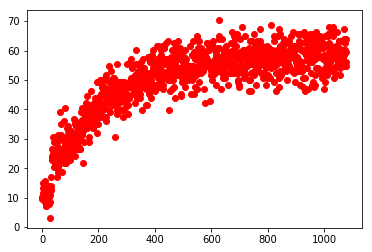

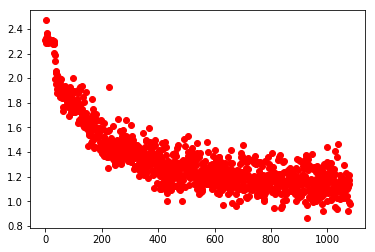

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

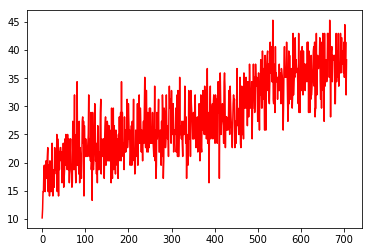

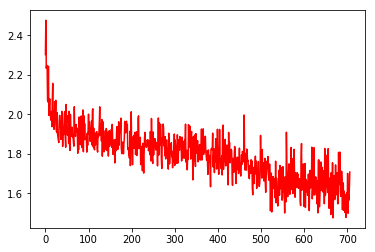

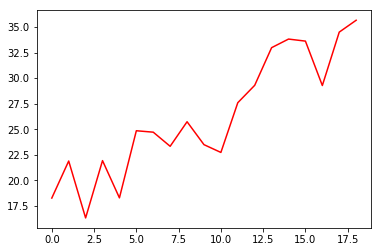

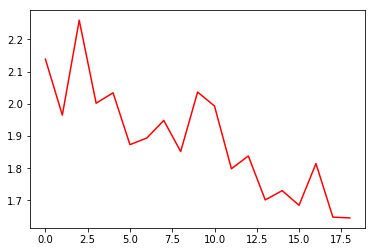

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()